# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [1]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import spatial_selection
import plotting
import time_utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
ccam_start_date = '1995-01-01'
ccam_end_date = '2014-12-31'

In [5]:
barpa_start_date = '1980-01-01'
barpa_end_date = '1989-12-31'

In [6]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## AGCD data

In [7]:
agcd_years = np.arange(1980, 2015, 1)
agcd_tmax_files = [f'/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_{year}.nc' for year in agcd_years]
agcd_tmax_files

['/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1980.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1981.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1982.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1983.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1984.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1985.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1986.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1987.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1988.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1989.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1990.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_t

In [8]:
agcd_ds = xr.open_mfdataset(agcd_tmax_files)

In [11]:
def read_agcd(ds, start_date, end_date):
    """Read and process AGCD data"""
    
    ds_subset = ds.sel({'time': slice(start_date, end_date)})
    
    agcd_monthly_clim = ds_subset.groupby('time.month').mean('time', keep_attrs=True)
    agcd_annual = time_utils.temporal_aggregation(ds_subset, 'A', 'mean', ['tmax'], input_freq='M')
    agcd_annual_clim = agcd_annual.mean('time', keep_attrs=True)
    
    agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)
    agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)
    
    agcd_annual_clim = agcd_annual_clim.compute()
    agcd_monthly_clim = agcd_monthly_clim.compute()
    
    return agcd_annual_clim, agcd_monthly_clim

In [12]:
agcd_annual_clim_ccam_times, agcd_monthly_clim_ccam_times = read_agcd(agcd_ds, ccam_start_date, ccam_end_date)

[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  5.2s


In [13]:
agcd_annual_clim_barpa_times, agcd_monthly_clim_barpa_times = read_agcd(agcd_ds, barpa_start_date, barpa_end_date)

[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.9s


## Parent data

In [14]:
parent_files = {}
parent_files['NorESM2-MM'] = [
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc',
]
parent_files['ACCESS-CM2'] = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-CM2_historical_r4i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-CM2_historical_r4i1p1f1_gn_20000101-20141231.nc'
]

In [15]:
def read_model_tasmax_data(file_list, obs_ds, aus_shape, time_bounds=None):
    """Read model tasmax data and calculate annual and monthly climatology"""
    
    ds = xr.open_mfdataset(file_list)
    input_units = ds['tasmax'].attrs['units']
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    try:
        ds = ds.drop('height')
    except ValueError:
        pass
    
    annual_clim = ds.mean('time', keep_attrs=True)
    monthly_clim = ds.groupby('time.month').mean('time', keep_attrs=True)

    if 'K' in input_units:
        print(f'Convert units from {input_units} to C')
        annual_clim['tasmax'] = annual_clim['tasmax'] - 273.13
        monthly_clim['tasmax'] = monthly_clim['tasmax'] - 273.13
        annual_clim['tasmax'].attrs['units'] = 'C'
        monthly_clim['tasmax'].attrs['units'] = 'C'
    
    regridder = xe.Regridder(ds, obs_ds, "bilinear")
    annual_clim = regridder(annual_clim)
    monthly_clim = regridder(monthly_clim)
    
    annual_clim = spatial_selection.select_shapefile_regions(annual_clim, aus_shape)
    monthly_clim = spatial_selection.select_shapefile_regions(monthly_clim, aus_shape)
    
    annual_clim = annual_clim.compute()
    monthly_clim = monthly_clim.compute()
    
    return monthly_clim, annual_clim

In [16]:
annual_clim_dict = {}
monthly_clim_dict = {}

for model in ['NorESM2-MM', 'ACCESS-CM2']:
    if model == 'NorESM2-MM':
        start_date = ccam_start_date
        end_date = ccam_end_date
    elif model == 'ACCESS-CM2':
        start_date = barpa_start_date
        end_date = barpa_end_date
    monthly_clim_dict[model], annual_clim_dict[model] = read_model_tasmax_data(
        parent_files[model], agcd_ds, aus_shape, time_bounds=[start_date, end_date],
    )

Convert units from K to C
[########################################] | 100% Completed | 16.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.3s
Convert units from K to C
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.0s


## RCM data

In [17]:
rcm_files = {}

rcm_files['BARPA'] = glob.glob('/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/*.nc')
rcm_files['BARPA'].sort()
rcm_files['BARPA']

['/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19800101-19801231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19810101-19811231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19820101-19821231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19830101-19831231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1

In [18]:
for model in ['BARPA']:
    monthly_clim_dict[model], annual_clim_dict[model] = read_model_tasmax_data(
        rcm_files[model], agcd_ds, aus_shape,
    )

Convert units from K to C
[########################################] | 100% Completed | 55.0s
[########################################] | 100% Completed | 31.8s
[########################################] | 100% Completed | 31.2s
[########################################] | 100% Completed | 31.0s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 31.1s


## Mean bias

/g/data/xv83/dbi599/model-evaluation/tasmax_annual-clim_CCAM-NorESM2-MM_1980-01-01_1989-12-31.png


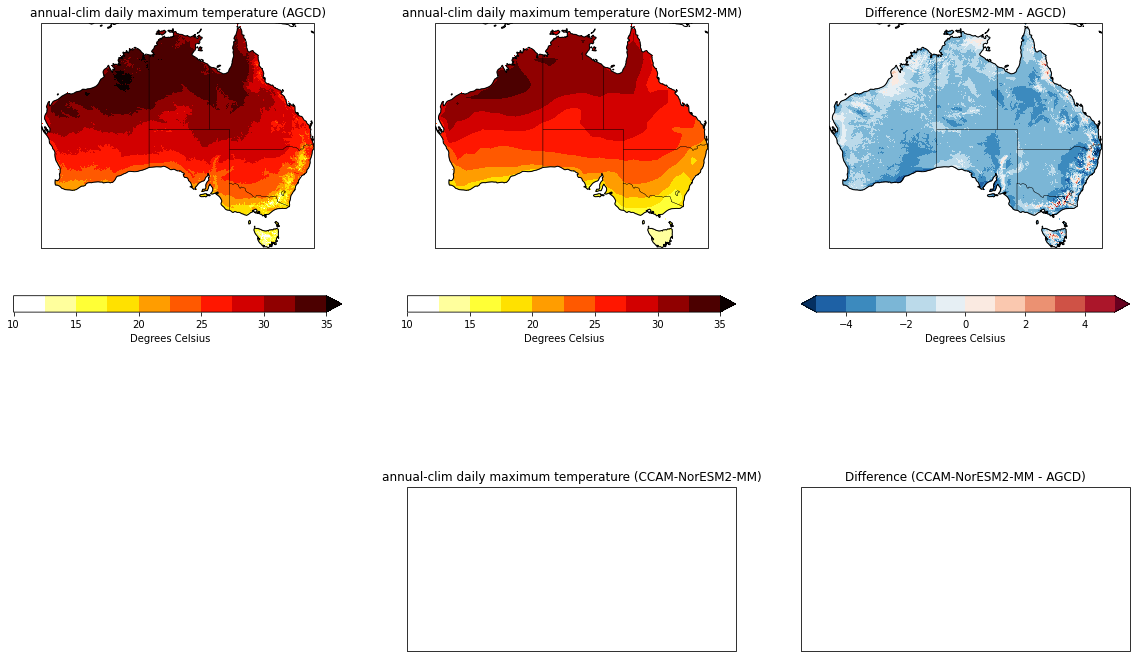

In [19]:
plotting.compare_agcd_gcm_rcm(
    agcd_annual_clim_ccam_times['tmax'],
    annual_clim_dict['NorESM2-MM']['tasmax'],
    'tasmax',
    'annual-clim',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    [10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30.0, 32.5, 35.0],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    rcm_da=None,
)

/g/data/xv83/dbi599/model-evaluation/tasmax_annual-clim_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


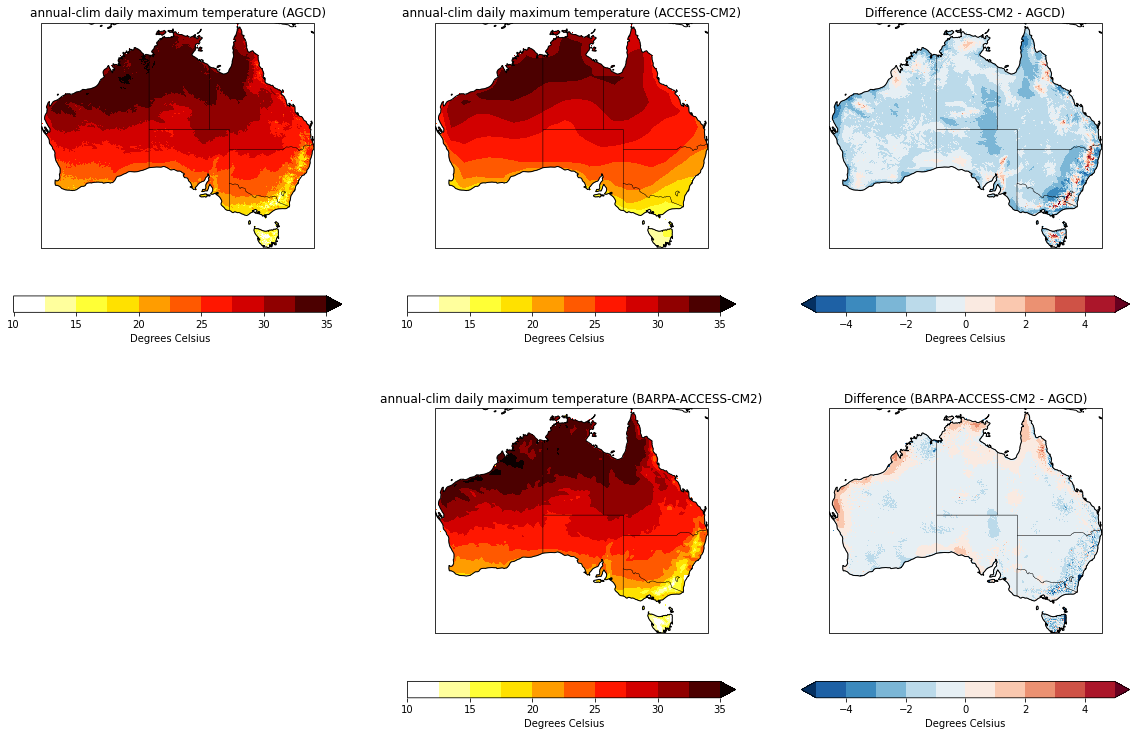

In [20]:
plotting.compare_agcd_gcm_rcm(
    agcd_annual_clim_barpa_times['tmax'],
    annual_clim_dict['ACCESS-CM2']['tasmax'],
    'tasmax',
    'annual-clim',
    'ACCESS-CM2',
    'BARPA',
    start_date,
    end_date,
    [10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30.0, 32.5, 35.0],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    rcm_da=annual_clim_dict['BARPA']['tasmax'],
)

## Temporal 

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/g/data/xv83/dbi599/model-evaluation/tasmax_seasonal-cycle_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


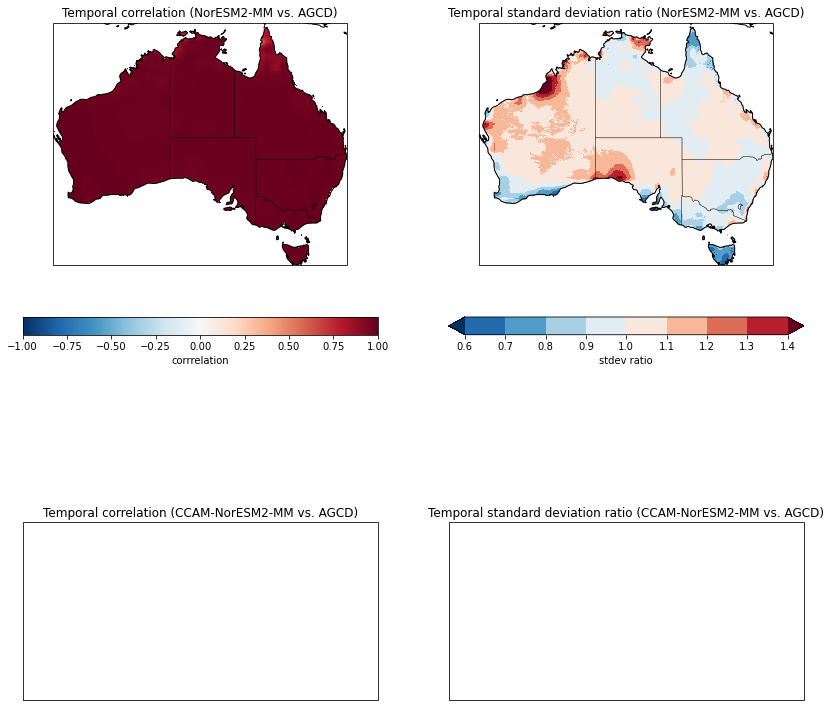

In [22]:
plotting.temporal_evaluation(
    monthly_clim_dict['NorESM2-MM']['tasmax'],
    agcd_monthly_clim_ccam_times['tmax'],
    'tasmax',
    'NorESM2-MM',
    'CCAM',
    ccam_start_date,
    ccam_end_date,
    std_ratio_levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
)

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeW

/g/data/xv83/dbi599/model-evaluation/tasmax_seasonal-cycle_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


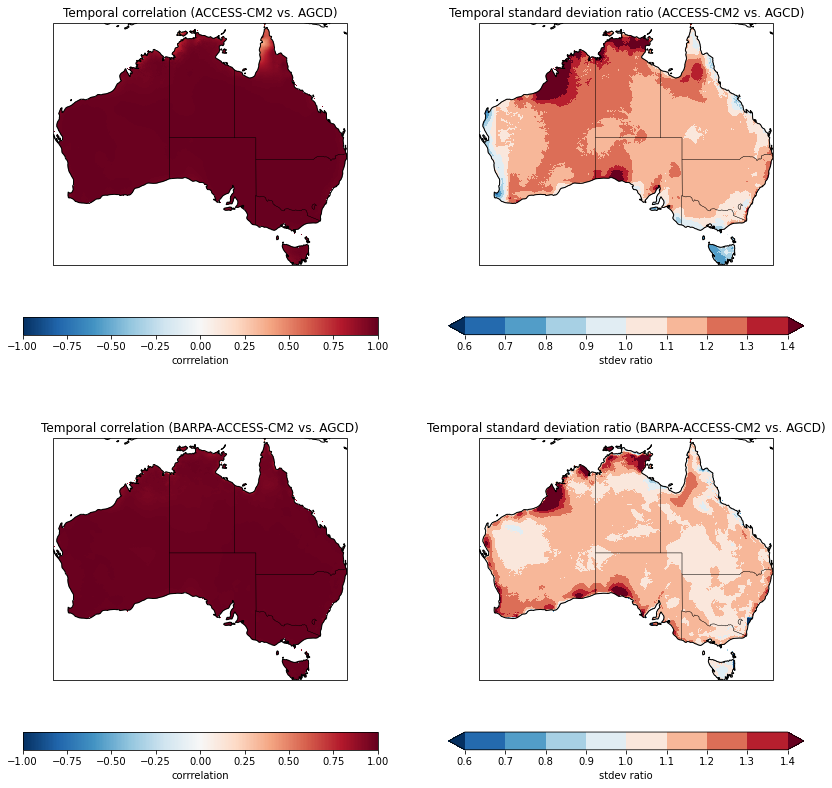

In [23]:
plotting.temporal_evaluation(
    monthly_clim_dict['ACCESS-CM2']['tasmax'],
    agcd_monthly_clim_barpa_times['tmax'],
    'tasmax',
    'ACCESS-CM2',
    'BARPA',
    barpa_start_date,
    barpa_end_date,
    rcm_monthly_clim=monthly_clim_dict['BARPA']['tasmax'],
    std_ratio_levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
)

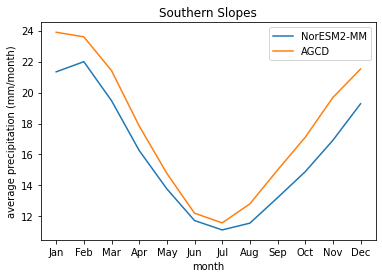

In [24]:
plotting.seasonal_cycle(
    monthly_clim_dict['NorESM2-MM']['tasmax'],
    agcd_monthly_clim_ccam_times['tmax'],
    'NorESM2-MM',
    cluster_name='Southern Slopes'
)